In [7]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torchvision
from torch.utils.data import random_split , DataLoader
import copy
import torchvision.transforms as transforms

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [8]:
#Load Dataset: CIFAR-10

transform = transforms.Compose([   # used in torchvision.datasets.CIFAR10()
    transforms.Resize(224),   # VGG19 expects 224x224
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5),
                         (0.5, 0.5, 0.5))
])
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

final_dataset = torch.utils.data.ConcatDataset([train_dataset, test_dataset])

In [9]:
from collections import Counter
targets = [target for _, target in final_dataset]

# Count the occurrences of each class
class_counts = Counter(targets)

print("Class Distribution:")
for class_id, count in class_counts.items():
    print(f"Class {class_id}: {count}")

Class Distribution:
Class 6: 6000
Class 9: 6000
Class 4: 6000
Class 1: 6000
Class 2: 6000
Class 7: 6000
Class 8: 6000
Class 3: 6000
Class 5: 6000
Class 0: 6000


In [10]:
total_size = len(final_dataset)
train_size = int(0.7*total_size) #70%
val_size = int(0.15*total_size) #15%
test_size = int(0.15*total_size) #15%

train_dataset, val_dataset, test_dataset = random_split(final_dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

In [11]:
from torchvision.models import vgg19, VGG19_Weights
model = vgg19(weights=VGG19_Weights.DEFAULT)
# Modify the classifier for the number of classes in CIFAR-10 (10 classes)
num_features = model.classifier[6].in_features
model.classifier[6] = torch.nn.Linear(num_features, 10)
model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd


Epoch 1/20
--------------------
Train Loss: 2.3156 Acc: 0.1020
Val Loss: 2.3048 Acc: 0.0992
✔️ Saved best model

Epoch 2/20
--------------------
Train Loss: 2.3051 Acc: 0.0995
Val Loss: 2.3045 Acc: 0.0992
✔️ Saved best model

Epoch 3/20
--------------------
Train Loss: 2.3048 Acc: 0.0977
Val Loss: 2.3029 Acc: 0.1026
✔️ Saved best model

Epoch 4/20
--------------------
Train Loss: 2.3037 Acc: 0.1008
Val Loss: 2.3037 Acc: 0.0990

Epoch 5/20
--------------------
Train Loss: 2.3037 Acc: 0.0991
Val Loss: 2.3030 Acc: 0.1003

Epoch 6/20
--------------------
Train Loss: 2.3035 Acc: 0.0984
Val Loss: 2.3033 Acc: 0.0944

Epoch 7/20
--------------------
Train Loss: 2.3041 Acc: 0.1009
Val Loss: 2.3053 Acc: 0.0994

Epoch 8/20
--------------------
Train Loss: 2.3042 Acc: 0.0997
Val Loss: 2.3031 Acc: 0.1014
Early stopping after 8 epochs due to no improvement in validation loss.


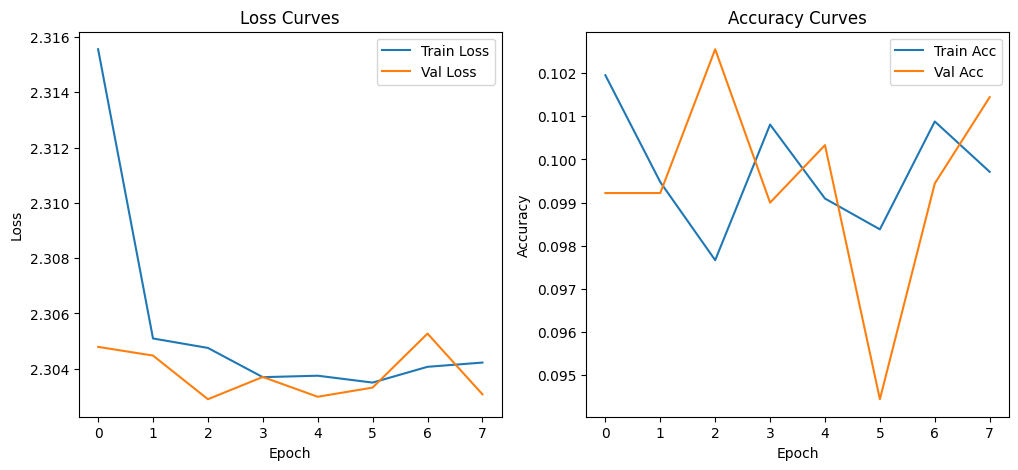

In [12]:
#Train-Val

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay =0.001)
num_epochs = 20
best_model_wts = copy.deepcopy(model.state_dict())
best_loss = float('inf')

# Early stopping parameters
early_stopping_patience = 5  # Number of epochs to wait for improvement
epochs_no_improve = 0

train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    print("-" * 20)

    # Training phase
    model.train()
    running_loss, running_corrects, total = 0.0, 0, 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = running_corrects.double() / total
    train_losses.append(epoch_loss)
    train_accs.append(epoch_acc.item())

    print(f"Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

    # Validation phase
    model.eval()
    running_loss, running_corrects, total = 0.0, 0, 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = running_corrects.double() / total
    val_losses.append(epoch_loss)
    val_accs.append(epoch_acc.item())

    print(f"Val Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

    # Save best weights and check for early stopping
    if epoch_loss < best_loss:
        best_loss = epoch_loss
        best_model_wts = copy.deepcopy(model.state_dict())
        torch.save(best_model_wts, "best_resnet50_cifar10.pth")
        print("✔️ Saved best model")
        epochs_no_improve = 0  # Reset counter
    else:
        epochs_no_improve += 1

    if epochs_no_improve == early_stopping_patience:
        print(f"Early stopping after {epoch+1} epochs due to no improvement in validation loss.")
        break  # Stop training loop


plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss Curves")

plt.subplot(1,2,2)
plt.plot(train_accs, label="Train Acc")
plt.plot(val_accs, label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy Curves")

plt.show()

In [13]:
model.load_state_dict(best_model_wts)

model.eval()
correct, total = 0, 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()

print(f"✅ Test Accuracy: {100 * correct / total:.2f}%")

✅ Test Accuracy: 9.53%
